# **3DBallEnv Reinforcement Learning**

### **Imports**

In [1]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import time
import os

### Torch
import torch
from torch import nn
from torch import optim

# Model
from model_util import MLP

### Torch RL
# Env
from torchrl.envs.libs import UnityMLAgentsEnv
from torchrl.envs.utils import step_mdp, check_env_specs

from torchrl.envs import Transform, TransformedEnv, Compose, Stack, RenameTransform, ExcludeTransform, ParallelEnv


# Modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.modules import ProbabilisticActor, TanhNormal
from torch.distributions import Categorical, Normal, Independent

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.collectors.utils import split_trajectories
from torchrl.data import LazyTensorStorage, ReplayBuffer, Composite
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from tensordict import TensorDict, TensorDictBase

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Create Torch Env**

In [3]:
def create_unity_env(graphics=False):
    try:
        env.close()
    except:
        pass

    env = TransformedEnv(UnityMLAgentsEnv(
        file_name="../../../envs/3DBall", worker_id=np.random.randint(10000), no_graphics=(not graphics),
    ))

    return env

### **Agents not Batched**

In [4]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_unity_env()
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [5]:
agent_root_key = env.observation_keys[0][0]
print(agent_root_key)
n_agents = len(env.action_spec[agent_root_key])
print(n_agents)
agents = list(env.action_spec[agent_root_key].keys())
print(agents)

group_0
12
['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4', 'agent_5', 'agent_6', 'agent_7', 'agent_8', 'agent_9', 'agent_10', 'agent_11']


In [6]:
env.rollout(100)

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        group_0: TensorDict(
            fields={
                agent_0: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size([14, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                        continuous_action: Tensor(shape=torch.Size([14, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                        done: Tensor(shape=torch.Size([14, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        terminated: Tensor(shape=torch.Size([14, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        truncated: Tensor(shape=torch.Size([14, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
                    batch_size=torch.Size([14]),
                    device=None,
                    is_shared=False),
                agent_10: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size

### **Batch Agents**

In [7]:
def batch_agents(env, out_key="agents"):
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    
    # Create transform
    stack = Stack(
        in_keys=[(agent_root_key, agent) for agent in agents], 
        out_key=(out_key,), 
        in_key_inv=(out_key,), 
        out_keys_inv=[(agent_root_key, agent) for agent in agents]
    )

    env.append_transform(stack)
    return env

def create_base_env(graphics=False):
    env = create_unity_env(graphics)
    env = batch_agents(env)
    return env

In [8]:
env = create_base_env()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [9]:
check_env_specs(env)
print_specs(env)

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
2025-09-26 05:07:42,924 [torchrl][INFO]    check_env_specs succeeded! [END]
action_spec: Composite(
    agents: Composite(
        continuous_action: BoundedContinuous(
            shape=torch.Size([12, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=None,
        shape=torch.Size([12]),
        data_cls=None),
    device=None,
    shape=torch.Size([]),
    data_cls=None)
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([12, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 1]), devi

In [10]:
td = env.rollout(100)
td

TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([15, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([15, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([15, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                terminated: Tensor(shape=torch.Size([15, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([15, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([15, 12]),
            device=None,
            is_shared=False),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size([15, 12, 8]), device=cpu, dtype=torch.float32, is_shared=Fals

## **Env Data Preprocessing**

In [11]:
env = create_base_env()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

### **Inspect Keys**

In [12]:
observation_key = env.observation_keys[0][1]
action_key = env.action_key[1]
print(f"observation_key: {observation_key}, action_key: {action_key}")

observation_shape = env.observation_spec["agents", observation_key].shape
action_shape = env.action_spec["agents", action_key].shape

print(f"observation_shape: {observation_shape}, action_shape: {action_shape}")

observation_key: VectorSensor_size8, action_key: continuous_action
observation_shape: torch.Size([12, 8]), action_shape: torch.Size([12, 2])


### **Inspect Action Space**

Actions are in [-1, 1] as expected. No need for further tampering

In [13]:
td = env.rollout(100)
actions_df = pd.DataFrame({
    "action": td["agents", action_key].reshape(-1)
})
actions_df.describe()

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


,action
count,312.000000
mean,-0.059369
std,0.585284
min,-0.994621
25%,-0.567445
50%,-0.069525
75%,0.428145
max,0.997868


In [14]:
space = env.action_spec["agents", action_key].space
print("low:", float(space.low[0, 0]), "high:", float(space.high[0, 0]))

low: -1.0 high: 1.0


### **Inspect Observation Space**

Observation are around z score normalized. No need for further tampering

In [15]:
obs_df = pd.DataFrame({
    "obs": td["agents", observation_key].reshape(-1)
})
obs_df.describe()

,obs
count,1248.000000
mean,0.188202
std,1.490789
min,-5.101198
25%,-0.446392
50%,0.000000
75%,0.616988
max,3.996076


In [16]:
env.observation_spec["agents", observation_key]

UnboundedContinuous(
    shape=torch.Size([12, 8]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)

### **Inspect Reward Space**

It looks like group_reward can be safely ignored. While the reward is -1 on failure, and 0.1 for surviving.

In [17]:
reward_df = pd.DataFrame({
    "reward": td["next", "agents", "reward"].reshape(-1),
    "group_reward": td["next", "agents", "group_reward"].reshape(-1)
})
reward_df.describe()

,reward,group_reward
count,156.000000,156.0
mean,0.085897,0.0
std,0.091192,0.0
min,-1.000000,0.0
25%,0.100000,0.0
50%,0.100000,0.0
75%,0.100000,0.0
max,0.100000,0.0


In [18]:
reward_df

,reward,group_reward
0,0.1,0.0
1,0.1,0.0
2,0.1,0.0
3,0.1,0.0
4,0.1,0.0
...,...,...
151,0.0,0.0
152,0.0,0.0
153,0.0,0.0
154,0.0,0.0


### **Finalize Environment**
The environment is already in a good state, the only thing to do is exclude group_reward.

In [19]:
def create_env(graphics=False):
    env = create_base_env(graphics)
    env.append_transform(
        ExcludeTransform(("agents", "group_reward"))
    )
    return env

In [20]:
env = create_env()
check_env_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [21]:
step_mdp(env.rollout(20))

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([14, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([14, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                reward: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([14, 12]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([14]),
    device=None,
    is_shared=False)

## **Create Models**

### **Config**

In [22]:
env = create_env()
observation_key = env.observation_keys[0][1]
action_key = env.action_key[1]

observation_shape = int(env.observation_spec["agents", observation_key].shape[-1])
action_shape = int(env.action_spec["agents", action_key].shape[-1])

HIDDEN_DIM = 256
N_BLOCKS = 3

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": observation_shape,
    "out_features": action_shape,
}

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [23]:
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 3, 'in_features': 8, 'out_features': 2}

### **Policy**

In [24]:
def create_policy(config):
    config = config.copy()
    config["out_features"] *= 2 # Double output dim, for loc and scale
    model = MLP(**config)

    normal_params_model = nn.Sequential(
        model,
        NormalParamExtractor()
    )
    logits_model = TensorDictModule(normal_params_model, in_keys=[("agents", observation_key)], out_keys=[("agents", "loc"), ("agents", "scale")])
    policy = ProbabilisticActor(
        module=logits_model,  
        distribution_class=TanhNormal,

        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[("agents", action_key)],

        return_log_prob=True,
        log_prob_key=("agents", "log_prob"),
        cache_dist=True,
    )

    return policy

### **Value**

In [25]:
def create_value(config):
    # Remove out_features from config
    config = config.copy()
    config["out_features"] = 1

    model = MLP(**config)
    value = TensorDictModule(model, in_keys=[("agents", observation_key)], out_keys=[("agents", "state_value")])
    return value

### **PPO Loss Module**

In [26]:
def make_loss_module(policy, value, epsilon, entropy_coef, gamma, lmbda):
    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=value,
        clip_epsilon=epsilon,
        entropy_coeff=entropy_coef,
        # normalize_advantage=True,
    )
    
    loss_module.set_keys(
        action=("agents", action_key),
        sample_log_prob=("agents", "log_prob"),
        value=("agents", "state_value"),

        advantage=("agents", "advantage"),
        value_target=("agents", "value_target"),

        reward=("agents", "reward"),
        done=("agents", "done"),
        terminated=("agents", "terminated"),
        # truncated can be left out, PPO uses done/terminated for bootstrapping
    )

    loss_module.make_value_estimator(ValueEstimators.GAE, gamma=gamma, lmbda=lmbda)

    return loss_module

### **Inspect**

In [27]:
policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

with torch.no_grad():
    td = env.rollout(100, policy=policy)
    loss_module.value_estimator(td)
data = step_mdp(td)["agents"]
data

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


TensorDict(
    fields={
        VectorSensor_size8: Tensor(shape=torch.Size([12, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([12, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        continuous_action: Tensor(shape=torch.Size([12, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([12, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([12, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([12, 12]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([12, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([12, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        state_value: Tensor(shape=torch.Size([12, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        t

## **Training**

### **Train Util**

In [28]:
# Returns dict of computed averages: return, episode_length, entropy, action_std
def compute_trajectory_metrics(tensordict_data):
    traj_data = split_trajectories(tensordict_data)

    reward = traj_data["next", "agents", "reward"] # [Tr, T, A, 1]
    if "collector" in traj_data:
        mask = traj_data["collector", "mask"].to(reward.dtype) # [Tr, T]
    elif "mask" in traj_data:
        mask = traj_data["mask"].to(reward.dtype) # [Tr, T]
    else:
        raise KeyError("No mask field found in:", tensordict_data)

    # 1. [Tr, T, A, 1] --(per episode return)--> [Tr, A] --(average return)--> float
    average_return = (reward * (mask.unsqueeze(-1).unsqueeze(-1))).sum(dim=(-3,-1)).mean().item()

    # 2. [Tr, T] --(episode length per trajectory (minumum of all agents))--> [Tr] --(average episode length)
    average_episode_length = mask.sum(dim=1).mean().item()
    
    # 3. Calculate entropy from dist, instead of sampled log_p, more accurate approximation
    loc, scale = traj_data["agents", "loc"], traj_data["agents", "scale"].clamp_min(1e-6) # clamp avoids nans in log(scale)
    loc, scale = loc.reshape(-1, loc.shape[-1]), scale.reshape(-1, scale.shape[-1]) # [Tr, T, A, action_dim]
    # Multivariate Normal [B, action_dim]
    dist = Independent(Normal(loc, scale), 1) 
    # Masked entropy [Tr, T, A]
    entropy = dist.entropy().reshape(*mask.shape, -1) * mask.unsqueeze(-1)
    # [Tr, T, A] --(mean entropy per agent (along the same timestep))--> [Tr, T]
    entropy = entropy.mean(dim=-1)
    # Total timesteps = mask.sum(), [Tr, T] --(average entropy)--> float
    entropy = (entropy.sum() / mask.sum()).item()

    # 4. action_std [T, A, action_dim]
    action_std = tensordict_data["agents", action_key].std().item()

    metrics = {
        "return": average_return,
        "episode_length": average_episode_length,
        "entropy": entropy,
        "action_std": action_std,
    }

    return metrics

# Uses loss module output tensordict and converts into a python dict with metrics
def loss_dict(loss_data, weight, keys, values):
    return {
        key: (loss_data[value].detach().mean().item(), weight) for key, value in zip(keys, values)
    }

class Stopwatch:
    def __init__(self):
        pass

    def start(self):
        self.start_time = time.time()

    def end(self):
        return time.time() - self.start_time


In [29]:
class Logger:
    '''
    Simple CSV Logger
    
    Args:
        - keys
        - log_path, name 
            - (optional) log_path is the log directory and must exist beforehand.

    Usage:

    logger = Logger(keys=keys, log_path=log_path, name=name) # (full_log_path = log_path/name.csv)
    # the history is retrieved on creation of the logger
    logger.reset() # reset the logger and log file if present
    # ...
    # Do some log ops
    # ...
    logger.next(print_row=True) # Writes this row, optionally prints it
    # ...
    history_df = logger.dataframe()

    Log Ops:
        logger.add({key: value}): sets column
        logger.sum({key: value}): adds from previous column
        logger.accumulate({key: value}): (weighted) average of calls (this row only, does not weight over previous rows)
            - in accumulate providing a value tuple of (value, weight) uses that weight, otherwise no tuple means weight=1
    '''

    def __init__(self, keys, log_path=None, name=None):
        self.keys = list(keys)
        self.set_keys = set(keys)
        self.df = pd.DataFrame(columns=self.keys)
        self.prev_row = {} # Helps with sums
        self.row = {}
        self.weights = {} # Helps with accumulation (potentially weighted)

        # Check for log path + name
        self.log_path = log_path
        if log_path and not name:
            raise KeyError("Log path provided without name")
        self.full_log_path = None

        if log_path:
            self.full_log_path = os.path.join(log_path, f"{name}.csv")

            # If it exists already, read current data
            if os.path.exists(self.full_log_path):
                try:
                    self.df = pd.read_csv(self.full_log_path)
                    self._set_prev_row()
                except:
                    print("FAILED TO READ LOG FILE, STARTING FROM SCRATCH.")

    def reset(self):
        # Ignore if no path
        if self.full_log_path is None:
            print("NO LOG PATH GIVEN: SKIPPING RESET")
            return

        # Try empty/create file (fails)
        with open(self.full_log_path, "w") as f:
            pass
        self.df = pd.DataFrame(columns=self.keys)
        self._set_prev_row()

    def _set_prev_row(self):
        if len(self.df) == 0: 
            self.prev_row = {}
            return
        self.prev_row = self.df.iloc[-1].to_dict()

    def check(self, key):
        if key not in self.set_keys:
            print(f"key: {key} not in keys: {self.keys}. SKIPPING KEY")
            return False
        return True
    
    @staticmethod
    def _add(dict_to, dict_from, key, value):
        dict_to[key] = (value + dict_from[key]) if key in dict_from else value

    def sum(self, entries):
        for key, value in entries.items():
            if not self.check(key): continue
            self._add(self.row, self.prev_row, key, value)


    def accumulate(self, entries):
        for key, value_data in entries.items():
            if not self.check(key): continue
            
            weight = value_data[1] if isinstance(value_data, tuple) else 1
            self._add(self.weights, self.weights, key, weight)

            value = value_data[0] if isinstance(value_data, tuple) else value_data
            self._add(self.row, self.row, key, value*weight)

    def add(self, entries):
        for key, value in entries.items():
            if not self.check(key): continue
            self.row[key] = value

    def next(self, print_row=False):
        # Finish accumulate
        for key, weight in self.weights.items():
            self.row[key] = self.row[key] / weight
        self.weights = {}

        # Combine and print
        df_next_row = pd.DataFrame(self.row, columns=self.keys, index=[len(self.df)])
        if print_row:
            print(df_next_row)

        if len(self.df) == 0:
            self.df = df_next_row
        else:
            self.df = pd.concat((self.df, df_next_row))
        # Reset prev row and current row
        self.prev_row = self.row
        self.row = {}

        # Write to csv
        if self.full_log_path:
            df_next_row.to_csv(self.full_log_path, mode='a', header=(len(self.df) == 1), index=False)

    def dataframe(self):
        return self.df
    

In [30]:
# Do the temporary replace trick for an atomic checkpoint update (will not get corrupted on sudden crashes)
def atomic_torch_save(state_obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with tempfile.NamedTemporaryFile(delete=False, dir=os.path.dirname(path)) as tmp:
        torch.save(state_obj, tmp)
        tmp.flush()
        os.fsync(tmp.fileno())
        tmp_path = tmp.name
    os.replace(tmp_path, path)

def load_model(path, name, policy, value):
    path = os.path.join(path, f"{name}.pt")
    if not os.path.exists(path):
        raise KeyError(f"Path does not exist: {path}")
    model_states = torch.load(path, weights_only=True)
    if policy:
        policy.load_state_dict(model_states["policy_state_dict"])
    if value:
        value.load_state_dict(model_states["value_state_dict"])

def save_model(path, name, policy, value):
    path = os.path.join(path, f"{name}.pt")
    state_obj = {
            "policy_state_dict": policy.state_dict(),
            "value_state_dict": value.state_dict(),
        }
    atomic_torch_save(state_obj, path)


In [31]:
class Checkpointer:
    '''
    Checkpoints training progress. Uses atomic ops so no corruption of files occur.
    
    Args:
        - ckpt_path, name

    Usage:

    checkpointer = Checkpointer(ckpt_path=ckpt_path, name=name)
    checkpointer.reset()
    # training ...
    checkpointer.save_progress(metric_key="metric",
    state_obj={
        "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "metric": metric
    })
    checkpoint = checkpointer.load_progress()
    # this is a dict containing values of (generation, metric) and state dict of others

    # save model, choose 'best' or 'latest, model_path is the directory, whats written is name.pt containing the keys specified from that state_obj.
    checkpointer.copy_model(ckpt_type='best', model_path=model_path, keys=("model",))
    '''
    def __init__(self, ckpt_path, name):
        self.path = ckpt_path
        self.name = name
        self.best_path = os.path.join(ckpt_path, f"{name}_best.ckpt")
        self.latest_path = os.path.join(ckpt_path, f"{name}_latest.ckpt")
        self.best_metric = self.get_best_metric()

    def reset(self):
        if os.path.exists(self.best_path):
            os.remove(self.best_path)
        if os.path.exists(self.latest_path):
            os.remove(self.latest_path)
        self.best_metric = float("-inf")
        
    def get_best_metric(self):
        if not os.path.exists(self.best_path):
            return float("-inf")
        try:
            checkpoint = torch.load(self.best_path, weights_only=True)
            return checkpoint["metric"]
        except:
            return float("-inf")

    def save_progress(self, metric_key, state_obj):
        atomic_torch_save(state_obj, self.latest_path)

        # Check if new best
        metric = state_obj[metric_key]
        if metric >= self.best_metric:
            atomic_torch_save(state_obj, self.best_path)
            self.best_metric = metric

    def load_progress(self):
        if not os.path.exists(self.latest_path):
            return None
        return torch.load(self.latest_path, weights_only=True)

    def copy_model(self, ckpt_type, model_path, keys):
        if ckpt_type == 'best':
            state_obj = torch.load(self.best_path, weights_only=True)
        elif ckpt_type == 'latest':
            state_obj = torch.load(self.latest_path, weights_only=True)
        else:
            raise KeyError(f"Invalid ckpt_type: {ckpt_type}. Expected: best or latest")

        state_obj = {key: state_obj[key] for key in keys}

        atomic_torch_save(state_obj, os.path.join(model_path, f"{self.name}.pt"))

### **Training Hyperparameters**

In [32]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

In [33]:
### Training Loop Params
WORKERS = os.cpu_count()
print("workers:", WORKERS)
STORAGE_DEVICE = device
GENERATION_SIZE = 2000 # 1000 is the truncation point for the env
TIMESTAMPS = GENERATION_SIZE * 50
EPOCHS = 10

# GD Params
MINIBATCH_SIZE = 64
LR = 3e-4
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params (None)

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-4

workers: 14


In [37]:
LOG_KEYS = [
    "generation", "time", "collection_time", "train_time",  # Training Progress Metrics
    "return", "episode_length",                             # Performance Metrics
    "entropy", "action_std",                                # Exploration Metrics
    "policy_loss", "kl_approx", "clip_fraction", "ESS",     # Policy Metrics
    "value_loss", "explained_variance",                     # Value Metrics
]

LOG_PATH = 'logs'
CKPT_PATH = 'ckpt'
MODEL_PATH = 'models'
NAME = 'testrun1'

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1
METRIC_KEY = "episode_length"

In [35]:
CONTINUE=False

### **Training Loop**

In [36]:
def train(policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
    

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
        frames_per_batch=GENERATION_SIZE, 
        total_frames=timestamps - start_generation*GENERATION_SIZE, 
        device=device, storing_device=STORAGE_DEVICE, update_at_each_batch=True
    )
    replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)


    ### TRAINING LOOP
    short_watch.start(); long_watch.start()
    policy.eval(); value.eval()
    for i, tensordict_data in enumerate(collector):
        # 0. Time collect
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})

        # 1. Compute Advantages and Value Target and Metrics
        tensordict_data = tensordict_data.to(device)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)
            metrics = compute_trajectory_metrics(tensordict_data)
        logger.add(metrics)

        # 2. Minibatch Gradient Descent Loop
        short_watch.start()
        policy.train(); value.train()
        replay_buffer.empty(); replay_buffer.extend(tensordict_data)
        for epoch in range(EPOCHS):
            for j, batch in enumerate(replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(
                    loss_dict(loss_data, weight,
                        ["value_loss", "explained_variance", "policy_loss", "kl_approx", "clip_fraction", "ESS"], 
                        ["loss_critic", "explained_variance", "loss_objective", "kl_approx", "clip_fraction", "ESS"], 
                    )
                )
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 3. Log results
        logger.sum({"generation": 1})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        # 4. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[METRIC_KEY]
            checkpointer.save_progress(metric_key=METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                METRIC_KEY: metric,
            })

        # 5. Start collection time
        short_watch.start()

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [39]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

train(policy, value, timestamps=TIMESTAMPS)

FAILED TO READ LOG FILE, STARTING FROM SCRATCH.


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/collectors/collectors.py:2815: UserWarning: frames_per_batch 2000 is not exactly divisible by the number of collector workers 14, this results in more frames_per_batch per iteration that requested.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

KeyboardInterrupt: 

Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 8)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 9)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 11)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 11)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 9)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 12)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 9)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 12)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 15)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 15)
Internal: deleting an al

## **Test**

In [38]:
# Load model
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)
load_model(MODEL_PATH, NAME, policy, value)

In [39]:
# Load history
logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
df = logger.dataframe()
df = df.set_index('generation')
df

,time,collection_time,train_time,return,episode_length,entropy,action_std,policy_loss,kl_approx,clip_fraction,ESS,value_loss,explained_variance
generation,,,,,,,,,,,,,
1.0,58.886402,43.176563,15.012649,1.032895,11.990431,2.282084,0.562579,-1.298679,0.135091,0.490381,0.849535,0.261948,-0.737003
2.0,117.239600,86.188752,29.290457,1.024763,11.904988,2.398350,0.589676,-1.109576,0.018333,0.182103,0.972055,0.328546,-0.251742
3.0,175.671459,129.488759,43.605402,1.021296,11.848700,2.254735,0.566791,-0.853632,0.021862,0.181563,0.971556,0.525857,-0.098360
4.0,233.331414,172.609014,57.412288,1.031240,11.990431,2.254270,0.573993,-0.510766,0.015068,0.170115,0.976276,0.434679,-0.049464
5.0,291.821421,215.787591,72.025871,1.050466,12.194647,2.219727,0.571102,-0.315221,0.008857,0.094415,0.984896,0.506831,-0.087520
6.0,350.120992,258.943789,86.386107,1.105986,12.720812,2.174381,0.561825,-0.130375,0.006787,0.077848,0.988307,0.493773,-0.023701
7.0,407.636461,302.162120,99.969812,1.131714,12.984456,2.221025,0.566599,-0.040507,0.010004,0.123306,0.982412,0.527899,-0.043188
8.0,465.440543,345.415737,113.807409,1.157784,13.224275,2.189654,0.557202,0.128739,0.017096,0.157307,0.968411,0.539650,0.002969
9.0,523.038694,388.659329,127.443966,1.205313,13.656675,2.058927,0.544527,0.149451,0.016264,0.179148,0.973988,0.537351,-0.067285


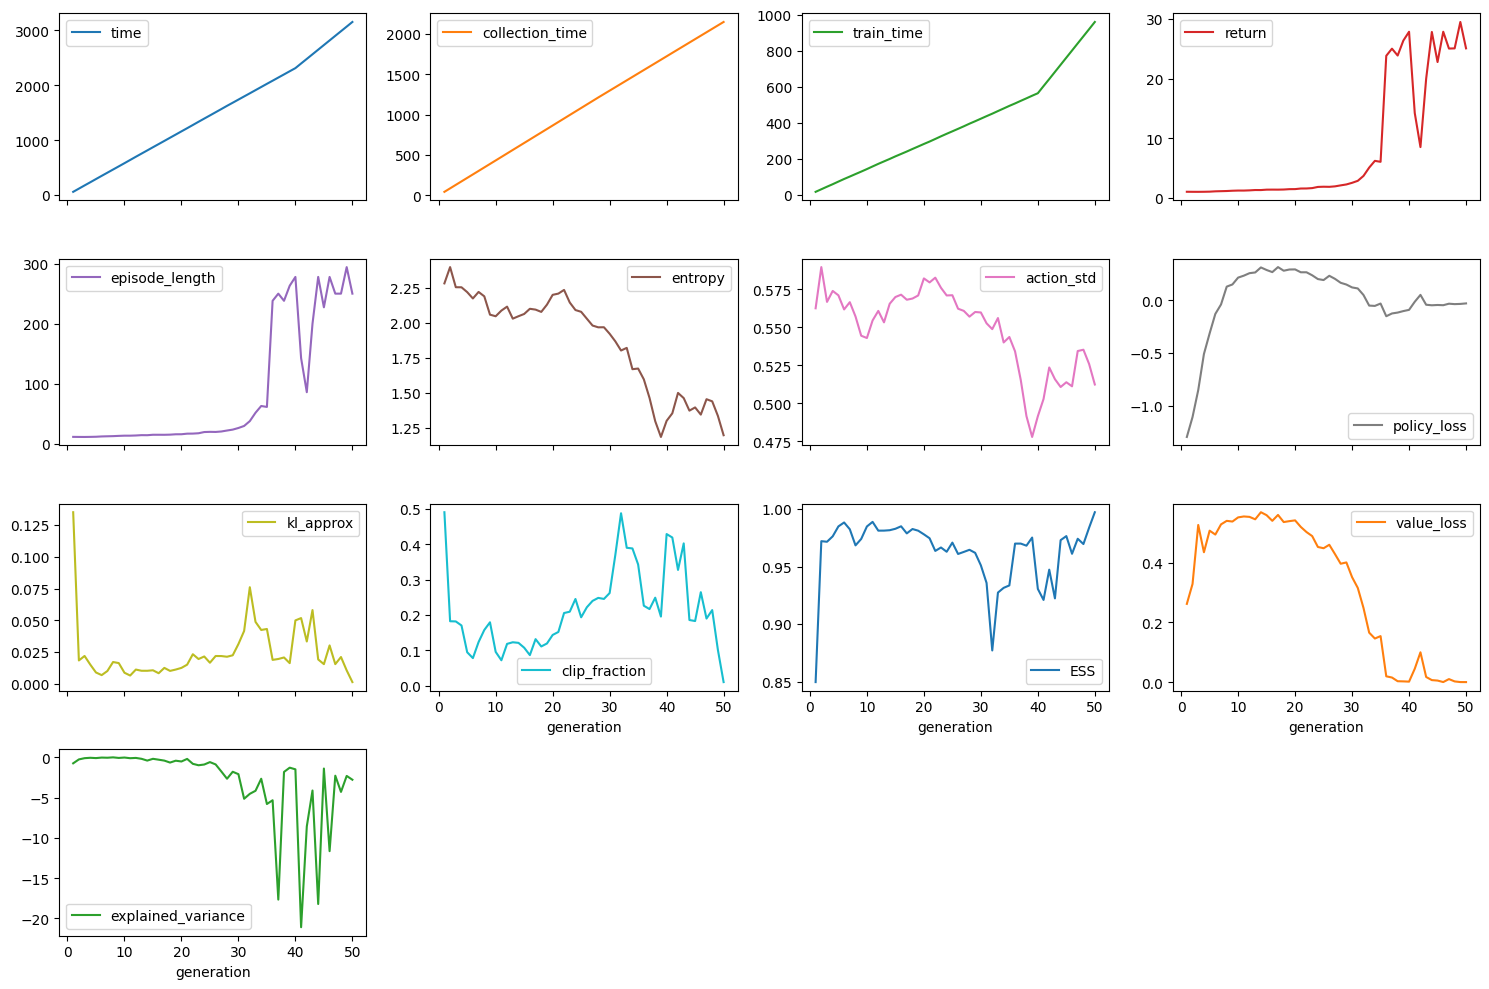

In [40]:
df.plot(subplots=True, layout=(4,4), figsize=(15, 10))
plt.tight_layout()

In [41]:
env = create_env(graphics=True)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [42]:
with torch.no_grad():
    data = env.rollout(1000, policy=policy)
data

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([1000, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([1000, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1000, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                loc: Tensor(shape=torch.Size([1000, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                log_prob: Tensor(shape=torch.Size([1000, 12]), device=cpu, dtype=torch.float32, is_shared=False),
                scale: Tensor(shape=torch.Size([1000, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([1000, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([1000, 12, 1]), device=cpu, dtype=torch.bool, is_shared=

In [45]:
env.close()

In [44]:
data["next", "agents", "truncated"].sum().item(), data["next", "agents", "terminated"].sum().item()

(12, 0)

In [43]:
# Aggregated done signal
data["next", "done"] = data["next", "agents", "done"].squeeze().any(-1)

compute_trajectory_metrics(data)

{'return': 100.0000228881836,
 'episode_length': 1000.0,
 'entropy': 1.4782472848892212,
 'action_std': 0.07713016122579575}

In [46]:
collection_percent, train_percent = df["collection_time"].iloc[-1]/df["time"].iloc[-1], df["train_time"].iloc[-1]/df["time"].iloc[-1]
collection_percent, train_percent = float(collection_percent)*100, float(train_percent)*100
other_percent = 100 - collection_percent - train_percent
print(f"percent time collecting: {collection_percent:.2f}, percent time training: {train_percent:.2f}, other percent: {other_percent:.2f}")

percent time collecting: 68.06, percent time training: 30.40, other percent: 1.54
